In [1]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
data_path = op.join(sys.path[0], '../../Experiment4/sub-01/mfmri.nii.gz')

In [3]:
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (360, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mfmri.nii.gz")

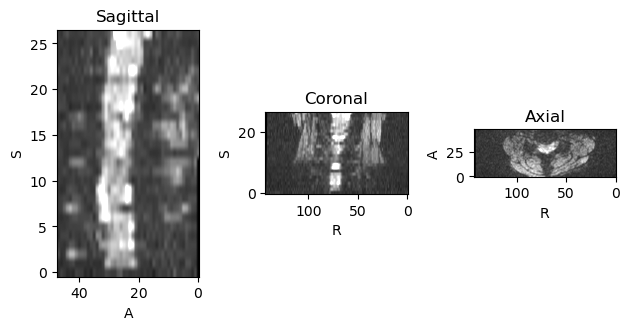

In [4]:
img.plot()

In [5]:
label_path = op.join(sys.path[0], '../../Experiment4/sub-01/mask_sc.nii.gz')

In [6]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mask_sc.nii.gz")

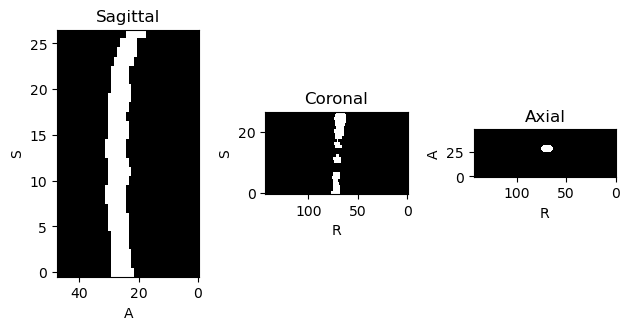

In [7]:
label.plot()

## FSLeyes

In [9]:
load('../../Experiment4/sub-01/mfmri.nii.gz')

Image(mfmri, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mfmri.nii.gz)

In [10]:
load('../../Experiment4/sub-01/mask_sc.nii.gz')

Image(mask_sc, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mask_sc.nii.gz)

In [11]:
path_original_data = '../../Experiment4/sub-01/mfmri'
path_moco_data = '../../Experiment4/sub-01/mfmri_bold_moco'
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

{}

In [12]:
load(path_moco_data)

Image(mfmri_bold_moco, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mfmri_bold_moco.nii.gz)

In [15]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof('../../Experiment4/sub-01/mfmri_bold_moco.par')
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.002491,-0.001841,0.001230,-0.001629,1.805690e-01,0.320531
1,0.002531,-0.002546,0.003252,0.089234,2.436300e-01,0.303875
2,0.002247,-0.002751,0.000175,0.059226,1.330590e-01,-0.225424
3,0.001727,-0.002531,-0.000017,0.107415,6.812880e-02,-0.236239
4,0.001269,-0.002585,-0.000087,0.098896,5.177820e-02,-0.253614
...,...,...,...,...,...,...
355,-0.001113,0.007527,-0.000914,-0.150550,5.208590e-02,-0.403817
356,-0.000318,0.004714,-0.001306,-0.224781,4.596800e-02,-0.430899
357,0.003461,0.005324,-0.000602,-0.237297,6.417940e-02,-0.443567
358,0.000030,0.006150,-0.000956,-0.259257,3.929510e-02,-0.394633


In [16]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

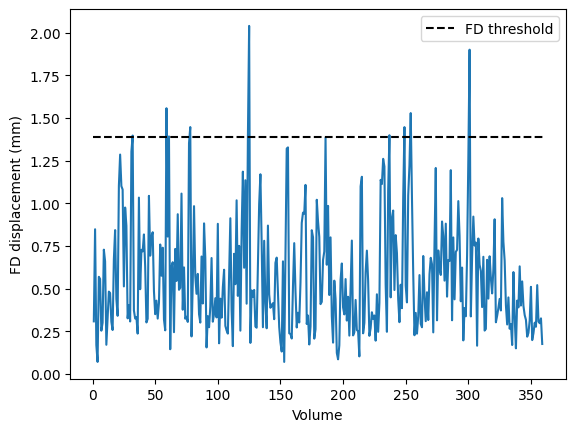

In [18]:
%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 360,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()